In [37]:
%load_ext autoreload
%autoreload 2


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
import basicFunctions as bf
import pickle

### Colorblind friendly colors:

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]


import matplotlib.style
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 15}
mpl.rc('font', **font)


import QuantRegUtils as qru

import os
import sys

path = os.getcwd()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
PATH = "../datasets/"
NAME = "compiled_"
inputdf = pd.read_csv(PATH + NAME +'X.csv') 
outputdf = pd.read_csv(PATH + NAME + 'Y.csv') 

In [3]:
variable_names = inputdf.columns[1:]

output_names = outputdf.columns[1:]

view = False
name_dict = {}
## View the names and indicies of each variable
for i, v in enumerate(variable_names):
    name_dict[v] = i
    if view:
        print(i, v)
        


Original shape of data, before cutting out extraneous data or selected HXR samples:
Input values: (286923, 77)
Output values: (286923,)
Removed 0.646515% of full dataset, eliminating extraneous values
Final shape of data, after cutting out extraneous data:
Input values: (285068, 76)
Output values: (285068,)


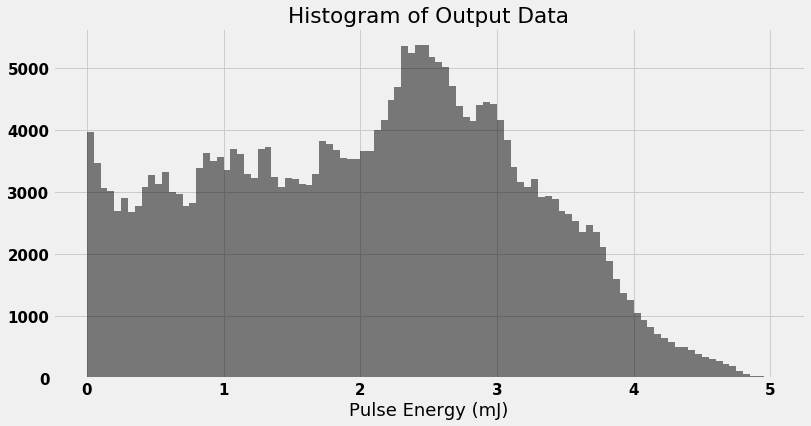

In [11]:
input_data = inputdf.to_numpy()
output_data = outputdf.to_numpy()
## Removing "index column"
output_data = output_data[:,1]


print("Original shape of data, before cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

mask = np.where(np.logical_and(output_data>0, output_data<5))

## apply mask and cut out "index column"

removed_perc = 100*(np.shape(output_data)[0] - np.shape(output_data[mask])[0])/(np.shape(output_data)[0] )

input_data = input_data[mask[0], 1:]
output_data = output_data[mask]

print("Removed {:2f}% of full dataset, eliminating extraneous values".format(removed_perc))



print("Final shape of data, after cutting out extraneous data:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

plt.figure(figsize = (12,6))
plt.title("Histogram of Output Data")
plt.xlabel("Pulse Energy (mJ)")
plt.hist(output_data, 100, facecolor = colors[0], alpha = 0.5)
plt.show()

In [12]:
# elements = np.arange(0,np.shape(output_data)[0], 14)
# n_ele = len(elements)
# print(n_ele)

# out_data = np.array([])
# inp_data = np.empty(shape = (0,76))


# for i in range(n_ele-1):
#     vec = output_data[elements[i]:elements[i+1]]
#     inps = input_data[elements[i]:elements[i+1],:]

    
#     mean = np.mean(vec)
#     inds = np.where(np.logical_or(vec > 1.2*mean, vec < 0.8*mean))
    
#     vec = np.delete(vec, inds[0]) 
#     inps = np.delete(inps, inds[0], axis = 0)

    
#     inp_data = np.vstack((inp_data, inps))
#     out_data = np.append(out_data, vec, axis = 0)
    
# print(100*(np.shape(input_data)[0] - np.shape(inp_data)[0])/np.shape(input_data)[0])

# np.save("20perc_inputs.npy", inp_data)
# np.save("20perc_outputs.npy", out_data)

In [13]:
# plt.figure(figsize = (26, 5))
# plt.title("Unfiltered Data")
# plt.ylabel("Pulse Energy")
# plt.plot(output_data)
# plt.show()

# plt.figure(figsize = (26, 5))
# plt.title("Filtered, Rejected 20% above/below moving mean (removed 10% of original dataset)")
# plt.ylabel("Pulse Energy")
# plt.plot(out_data)
# plt.show()

In [14]:
# elements = np.arange(0,np.shape(output_data)[0], 14)
# n_ele = len(elements)
# print(n_ele)
# out_data = np.array([])
# inp_data = np.empty(shape = (0,76))


# for i in range(n_ele-1):
#     vec = output_data[elements[i]:elements[i+1]]
#     inps = input_data[elements[i]:elements[i+1],:]

    
#     mean = np.mean(vec)
#     inds = np.where(np.logical_or(vec > 1.1*mean, vec < 0.9*mean))
    
#     vec = np.delete(vec, inds[0]) 
#     inps = np.delete(inps, inds[0], axis = 0)

    
#     inp_data = np.vstack((inp_data, inps))
#     out_data = np.append(out_data, vec, axis = 0)
    
# print(100*(np.shape(input_data)[0] - np.shape(inp_data)[0])/np.shape(input_data)[0])

# np.save("10perc_inputs.npy", inp_data)
# np.save("10perc_outputs.npy", out_data)

In [15]:
# plt.figure(figsize = (26, 5))
# plt.title("Unfiltered Data")
# plt.ylabel("Pulse Energy")
# plt.plot(output_data)
# plt.show()

# plt.figure(figsize = (26, 5))
# plt.title("Filtered, Rejected 10% above/below moving mean (removed 20% of original dataset)")
# plt.ylabel("Pulse Energy")
# plt.plot(out_data)
# plt.show()

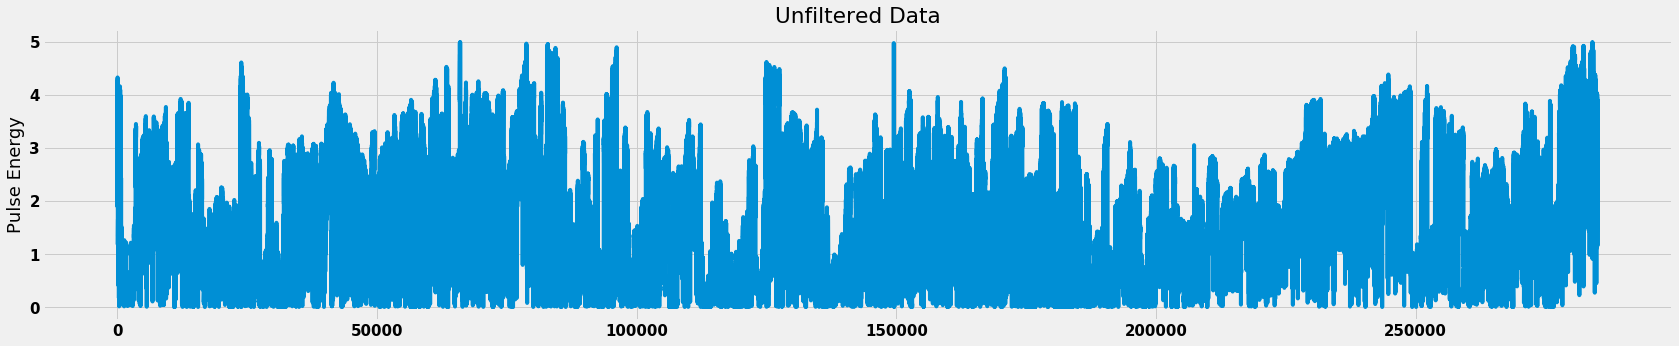

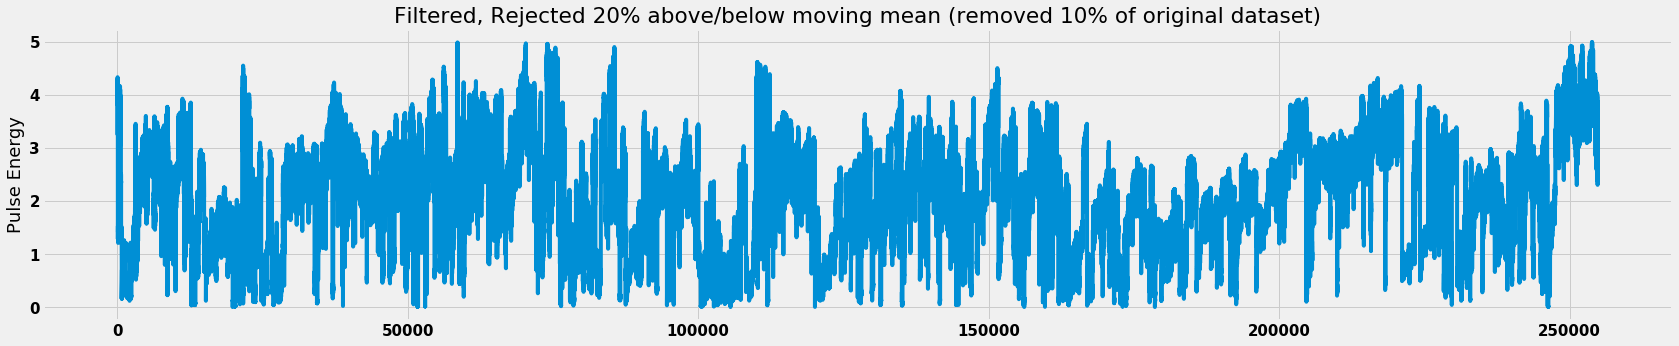

In [38]:

input_data = np.load("20perc_inputs.npy")
out_data = np.load("20perc_outputs.npy")

n = np.shape(input_data)[0]


plt.figure(figsize = (26, 5))
plt.title("Unfiltered Data")
plt.ylabel("Pulse Energy")
plt.plot(output_data)
plt.show()

plt.figure(figsize = (26, 5))
plt.title("Filtered, Rejected 20% above/below moving mean (removed 10% of original dataset)")
plt.ylabel("Pulse Energy")
plt.plot(out_data)
plt.show()

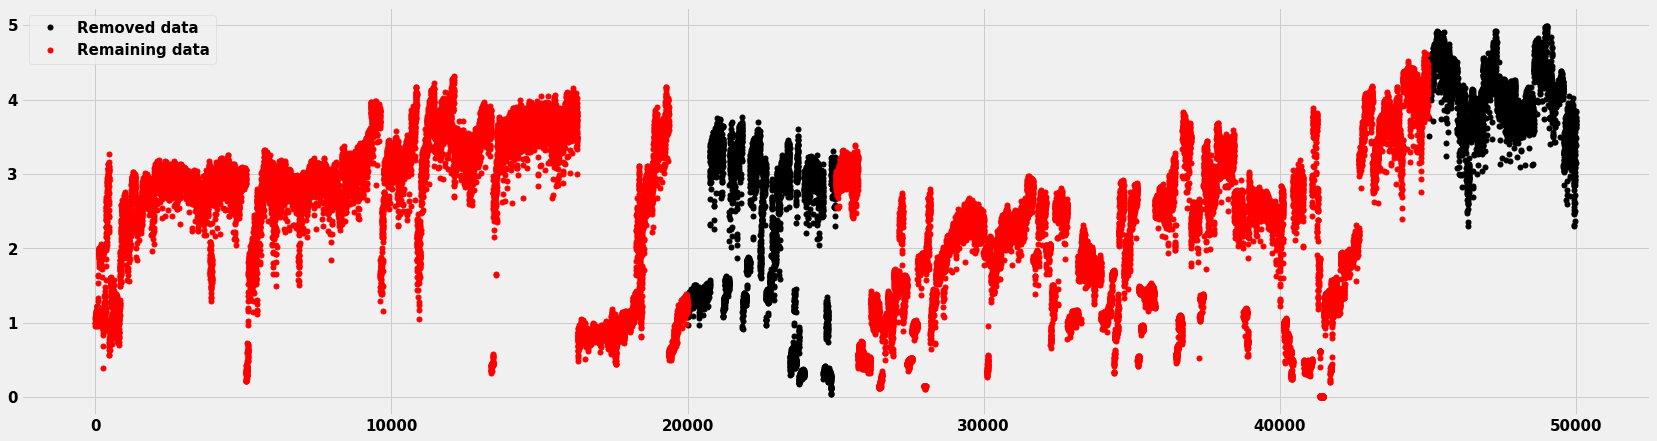

In [39]:

## the following is some "bookkeeping" of data removed, and data used in training.

input_cut = input_data[n-50000:]
output_cut = out_data[n-50000:]
allinds = np.arange(0,50000)

## Indices that will be removed
a = 20000
b = 25000

c = 45000
d = 50000

inds_removed = np.concatenate( (np.arange(a,b), np.arange(c,d)))

plt.figure(figsize= (26,7))

plt.plot(inds_removed, output_cut[inds_removed], '.k', markersize = 10, label = "Removed data")

## Remaining training data
input_rem = np.delete(input_cut, inds_removed, axis = 0)

output_rem = np.delete(output_cut, inds_removed)

remaining = np.delete(allinds, inds_removed)

plt.plot(remaining, output_rem, '.r', markersize = 10, label = "Remaining data")
plt.legend()
plt.show()

In [42]:
PATH = os.path.join(path + "/../models/Filtered/20Perc/")
MODEL_NAME = ""
loading = False
if loading:
    x_scales = np.load(PATH + MODEL_NAME + "x_scales.npy")
    x_offsets = np.load(PATH + MODEL_NAME + "x_offsets.npy")
    y_scale = np.load(PATH + MODEL_NAME + "y_scale.npy")
    y_offset = np.load(PATH + MODEL_NAME + "y_offset.npy")
    x_scaled = np.load(PATH + MODEL_NAME + "x_scaled.npy")
    y_scaled = np.load(PATH + MODEL_NAME + "y_scaled.npy")
else:
    x_scaled, x_scales, x_offsets = bf.do_scaling(input_data, -1, 1)
    y_offset, y_scale= bf.get_scale(output_data)

    y_scaled = bf.scale_data(output_data, y_offset, y_scale, -1,1)
    
    np.save(PATH + MODEL_NAME + "x_scales.npy", x_scales)
    np.save(PATH + MODEL_NAME + "x_offsets.npy", x_offsets)
    np.save(PATH + MODEL_NAME + "y_scale.npy", y_scale)
    np.save(PATH + MODEL_NAME + "y_offset.npy", y_offset)
    np.save(PATH + MODEL_NAME + "x_scaled.npy", x_scaled)
    np.save(PATH + MODEL_NAME + "y_scaled.npy", y_scaled)

x, y, scd = qru.scaling_and_dict(input_data, output_data)

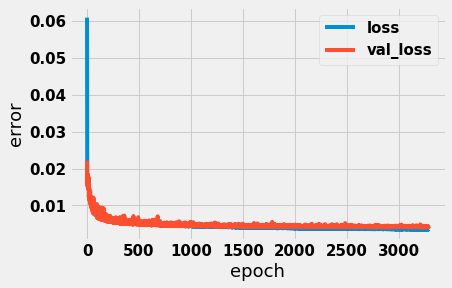

Time to run in minutes was:  20.308060598373412
Training Complete
Completed


In [43]:
training_models = True

if training_models:

    X_train, X_test, Y_train, Y_test = train_test_split(input_rem, output_rem, test_size = 0.2, random_state = 42)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)

    input_dict = {}
    input_dict["train"] = X_train
    input_dict["val"] = X_val
    input_dict["test"] = input_cut

    output_dict = {}
    output_dict["train"] = Y_train
    output_dict["val"] = Y_val
    output_dict["test"] = output_cut

    with open(PATH + "inputs.pkl", 'wb') as f:
        pickle.dump(input_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(PATH + "outputs.pkl", 'wb') as f:
        pickle.dump(output_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    #### Set up some parameters
    epochs = 5000
    batch_size = 4096

    median = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "median_pred_", QUANTILE = 0.5)
    median.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)


    upper = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "upper_pred_", QUANTILE = 0.975)
    upper.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)


    lower = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "lower_pred_", QUANTILE = 0.025)
    lower.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size, saving = False)
    
    print("Completed")
else:

    MODEL_NAME = ""
    NN = PATH + MODEL_NAME + "median_pred_Model_Weights.h5"
    LB = PATH + MODEL_NAME + "lower_pred_Model_Weights.h5"
    UB = PATH + MODEL_NAME + "upper_pred_Model_Weights.h5"

    with open(PATH + "inputs.pkl", 'rb') as f:
        input_dict = pickle.load(f, encoding="utf-8")

    with open(PATH + "outputs.pkl", 'rb') as f:
        output_dict = pickle.load(f)

    median = qru.Model(PATH = PATH, NAME = NN, scaling_dict = scd)   
    median.load()

    upper = qru.Model(PATH = PATH, NAME = UB, scaling_dict = scd)   
    upper.load()

    lower = qru.Model(PATH = PATH, NAME = LB, scaling_dict = scd)   
    lower.load()
    print("All models loaded")
    


    
    

In [44]:
out = output_cut
median_pred = median.evaluate(input_cut)
ub_pred = upper.evaluate(input_cut)
lb_pred = lower.evaluate(input_cut)


In [45]:
coverage = np.logical_and(out > lb_pred[:,0], out < ub_pred[:,0])
coverage = np.array([int(elem) for elem in coverage])
coverage_percent = 100*np.sum(coverage)/len(out)

mse, mae = qru.calc_mse_and_mae(median_pred[:,0], out)

print("The percent of measured values within the confidence interval is: {:2.2f}%".format(coverage_percent))
print("MSE:", mse)
print("MAE:", mae)

The percent of measured values within the confidence interval is: 79.60%
MSE: 0.23255665472809542
MAE: 0.22381887143885157


/global/homes/l/lgupta/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/global/homes/l/lgupta/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


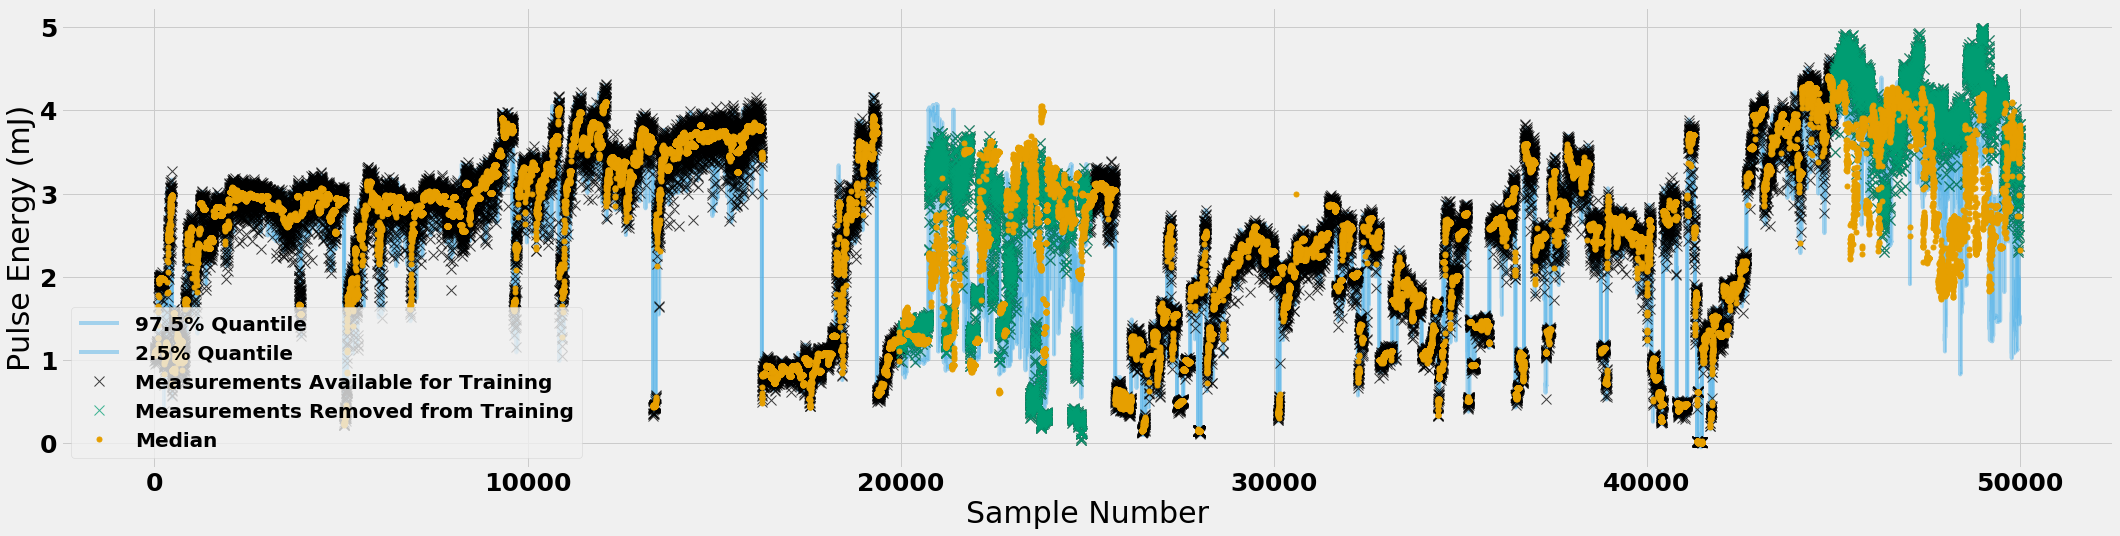

In [46]:
mpl.style.use('seaborn-bright')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 25}
mpl.rc('font', **font)

markersize = 10
plt.figure(figsize = (30, 8))
plt.plot(allinds, ub_pred[:,0], color = colors[2], alpha = 0.5, label = "97.5% Quantile", markersize = markersize)
plt.plot(allinds, lb_pred[:,0], color = colors[2], alpha = 0.5, label = "2.5% Quantile",markersize = markersize)
plt.plot(allinds, out, 'x', color = colors[0], alpha = 0.75 , label = "Measurements Available for Training",markersize = markersize)
plt.plot(inds_removed, out[inds_removed], 'x', color = colors[3], alpha = 0.75 , label = "Measurements Removed from Training",markersize = markersize)
plt.plot(allinds, median_pred[:,0], '.', color = colors[1], label = "Median",markersize = markersize)
plt.fill_between(allinds, ub_pred[:,0], lb_pred[:,0], color = colors[2], alpha = 0.5)

plt.legend(fontsize = 20)
plt.xlabel("Sample Number")
plt.ylabel("Pulse Energy (mJ)")
plt.tight_layout()
## Saving:
# plt.savefig("interpolation_1.png", transparent = True)
plt.show()

/global/homes/l/lgupta/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/global/homes/l/lgupta/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


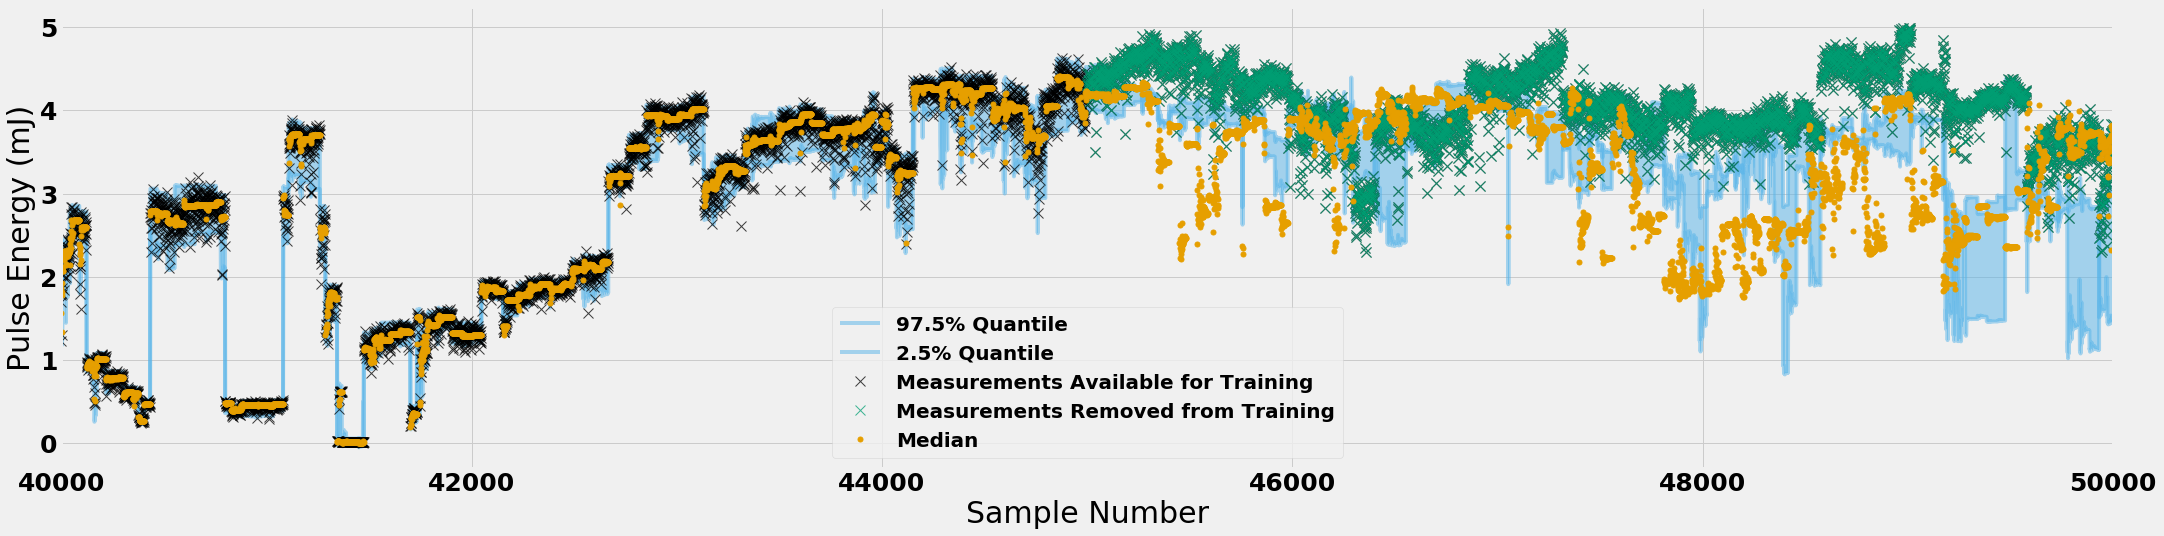

In [49]:
mpl.style.use('seaborn-bright')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 25}
mpl.rc('font', **font)

markersize = 10
plt.figure(figsize = (30, 8))
plt.plot(allinds, ub_pred[:,0], color = colors[2], alpha = 0.5, label = "97.5% Quantile", markersize = markersize)
plt.plot(allinds, lb_pred[:,0], color = colors[2], alpha = 0.5, label = "2.5% Quantile",markersize = markersize)
plt.plot(allinds, out, 'x', color = colors[0], alpha = 0.75 , label = "Measurements Available for Training",markersize = markersize)
plt.plot(inds_removed, out[inds_removed], 'x', color = colors[3], alpha = 0.75 , label = "Measurements Removed from Training",markersize = markersize)
plt.plot(allinds, median_pred[:,0], '.', color = colors[1], label = "Median",markersize = markersize)
plt.fill_between(allinds, ub_pred[:,0], lb_pred[:,0], color = colors[2], alpha = 0.5)

plt.legend(fontsize = 20)
plt.xlabel("Sample Number")
plt.ylabel("Pulse Energy (mJ)")
plt.tight_layout()
## Saving:
# plt.savefig("interpolation_1.png", transparent = True)

plt.xlim(40000,50000)

plt.show()
